In [1]:
import pandas as pd

bbox = pd.read_csv('/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv')
bbox.columns

Index(['StudyInstanceUID', 'x', 'y', 'width', 'height', 'slice_number'], dtype='object')

In [4]:
fract_uid = '1.2.826.0.1.3680043.10051'
no_frac_uid = '1.2.826.0.1.3680043.30038'
base_dir = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection'
import cv2
import pydicom as dicom
import numpy as np
def load_dicom(path):
  img = dicom.dcmread(path)
  img.PhotometricInterpretation = 'YBR_FULL'
  data = img.pixel_array
  data = data - np.min(data)
  if np.max(data) != 0:
    data = data / np.max(data)
  data = (data * 255).astype(np.uint8)
  return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

In [5]:
# for i in df_data_list:
import os
location = f'{base_dir}/train_images/{no_frac_uid}'
loc_list = os.listdir(location)
for i in loc_list:
    os.makedirs(f'{base_dir}/image_data/{no_frac_uid}', exist_ok=True)
    i_splits = i.split('/')
    filename = i_splits[-1]
    filename = filename.replace('dcm', 'png')
    # print(filename)
    # break
    filepath = f'{base_dir}/image_data/{no_frac_uid}/{filename}'
    # print(filepath)
    img, something = load_dicom(f'{location}/{i}')
    cv2.imwrite(filepath, img)

In [3]:
import shutil
shutil.make_archive(f'{base_dir}/image_data/{no_frac_uid}', format='zip', root_dir=f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/image_data/{no_frac_uid}')

'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/image_data/1.2.826.0.1.3680043.30038.zip'

In [10]:
!pip install dcm2niix


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.4/451.4 kB 7.3 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dcm2niix: filename=dcm2niix-1.0.20220715-cp38-cp38-macosx_10_16_x86_64.whl size=440253 sha256=9f90010d8bdfe5ae2226950a059edde2b11974417230788ea451ef5692ed44dc
  Stored in directory: /Users/jarvis/Library/Caches/pip/wheels/6e/ad/be/de4334a6bec64465e158e35614ccbff0fbd9080f684c1daace
Successfully built dcm2niix


In [6]:
import dicom2nifti

path_to_dicom_series = f'{base_dir}/train_images/{fract_uid}'

# dicom2nifti.convert_directory(path_to_dicom_series, base_dir)

In [13]:
!dcm2niix -z y -f %p_%t_%s -o $base_dir $path_to_dicom_series

Compression will be faster with 'pigz' installed http://macappstore.org/pigz/
Chris Rorden's dcm2niiX version v1.0.20220505  Clang14.0.3 x86-64 (64-bit MacOS)
Found 272 DICOM file(s)
DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051/1.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051/10.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051/100.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051/101.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/tra

In [20]:
import pydicom
import nibabel as nib

nii_example = nib.load(f'{base_dir}/_0_751986239.nii')

# Convert to numpy array
seg = nii_example.get_fdata()
seg.shape

# ds = pydicom.read_file(f'{base_dir}/train_images/{fract_uid}/1.dcm')
# print(ds)

(512, 512, 272)

In [21]:
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
seg.shape

(272, 512, 512)

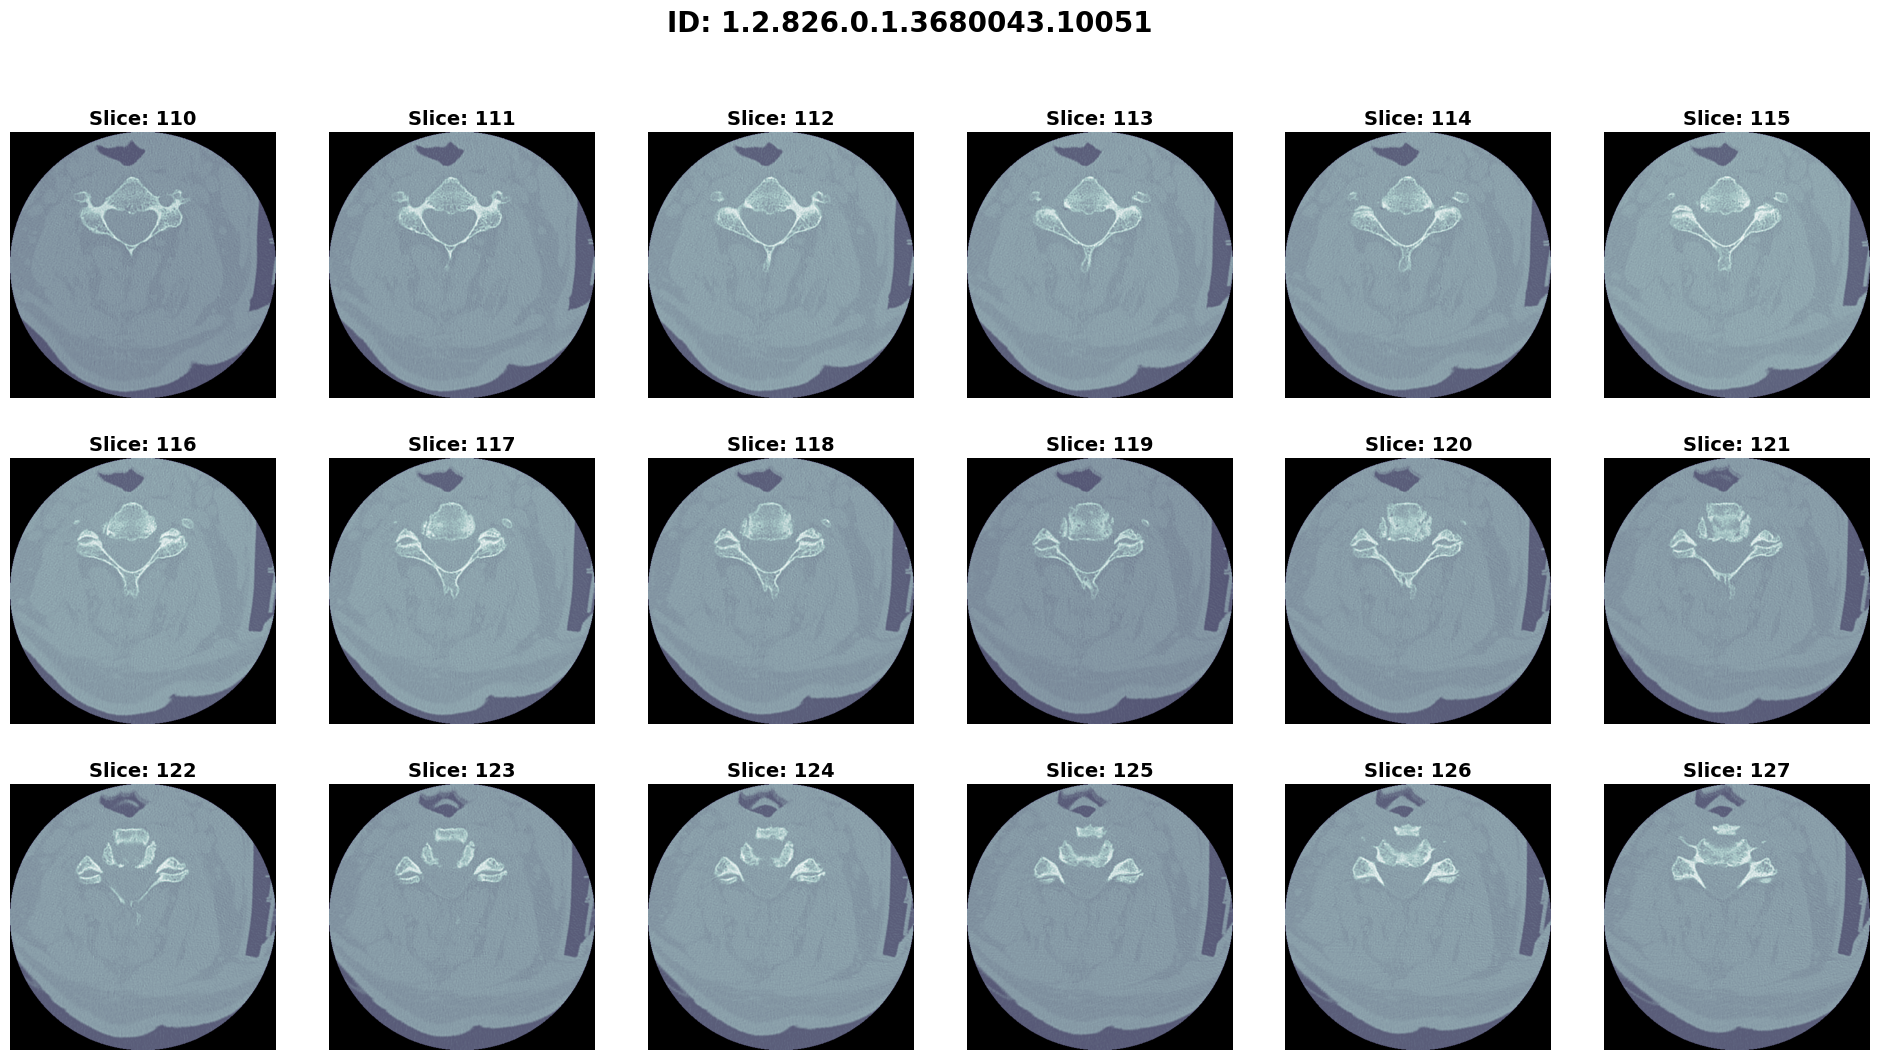

In [24]:
# Plot images
start = 110
import matplotlib.pyplot as plt

patient_id_1 = '1.2.826.0.1.3680043.12281'
patient_id = fract_uid
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

for i in range(start,start+18):
    mask = seg[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(mask, cmap='bone')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

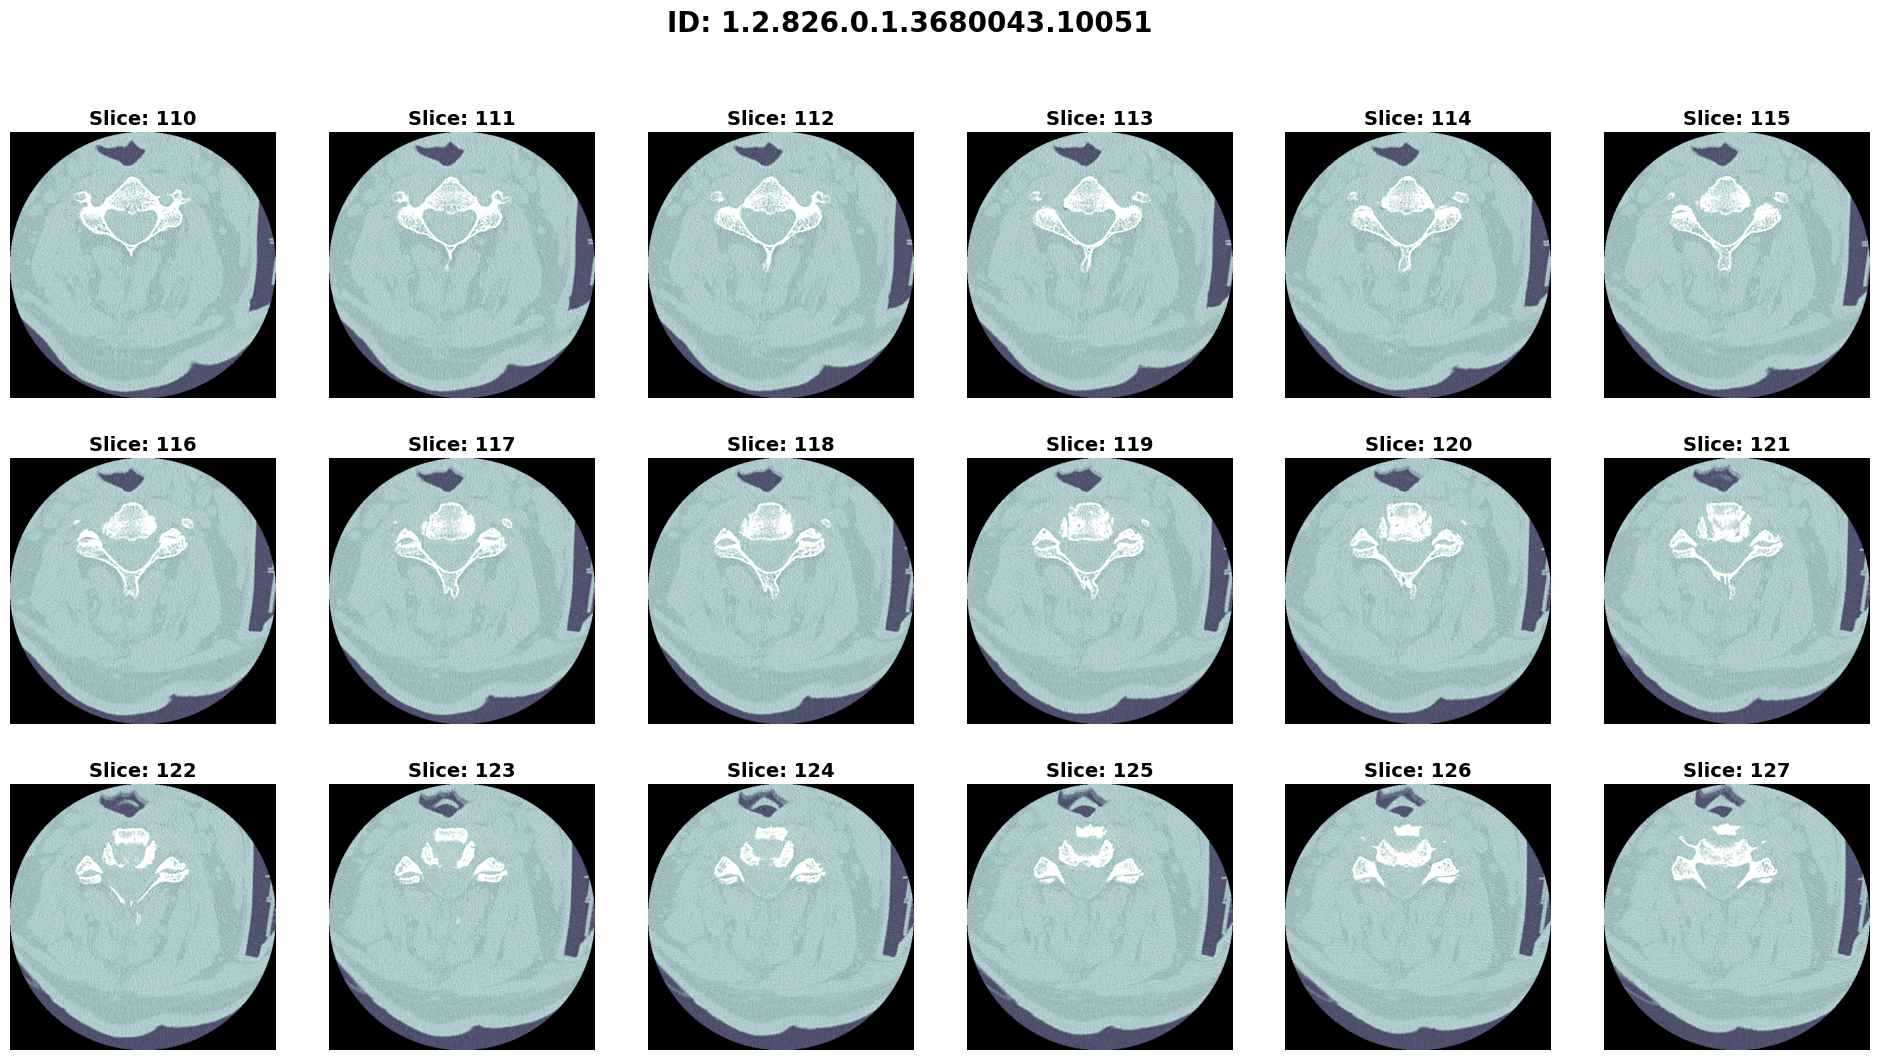

In [27]:
import re
from glob import glob
from pydicom.pixel_data_handlers.util import apply_voi_lut

patient_id = fract_uid
# patient_id = '1.2.826.0.1.3680043.1573'
dcm_paths = glob(f"{base_dir}/train_images/{patient_id}/*")
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]
dcm_paths.sort(key=natural_keys)

# Get images
files = [pydicom.dcmread(path) for path in dcm_paths]
# files_1 = [seg[:, ::-1, ::-1].transpose(2, 1, 0) for seg in files]
images = [apply_voi_lut(file.pixel_array, file) for file in files]

# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

start = 110
for i in range(start,start+18):
    img = images[i]
    file = files[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')
